#SpaceX Project


This is a combination of a number of tasks completed as part of the IBM Data Science Professional Certificate Capstone course. In that course most of these tasks were split up so as to allow students to complete follow on tasks in the event that they were stuck on previous ones. i.e. rather than relying on data the student scraped from wikipedia or the SpaceX API, data was given for the analysis tasks. Here I combine the webscraping, data cleaning, and exploratory data analysis tasks together as they used the same data set.

##Outline

The major tasks presented here are
1. Webscraping from Wikipedia and cleaning
2. Conducting exploratory data analysis with SQL
3. Visualizations with matplotlib and seaborn
4. Machine learning modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# 1. Webscraping
In the IBM lab we used Beautiful Soup and our role was essentially to fill in the skeletons of a number of prewritten functions in order to do most of the below process. Here instead I have chosen to use the pandas read_url function instead.

We used a static url in the IBM course to scrape from Wikipedia. I will continue this here in the event that the page changes.


In [ ]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

Here we can see there are 25 total tables, and that there is a difference between the names of the columns between table 2 and 3. Specifically the column 'Version, Booster [b]' has a space between Booster and [b] in one but not the other.

In [ ]:
url=pd.read_html(static_url)
print(f'Total tables:{len(url)}')
url[2].columns

Total tables:25


Index(['Flight No.', 'Date and time (UTC)', 'Version, Booster [b]',
       'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer',
       'Launch outcome', 'Booster landing'],
      dtype='object')

In [ ]:
url[3].columns

Index(['Flight No.', 'Date and time (UTC)', 'Version, Booster[b]',
       'Launch site', 'Payload[c]', 'Payload mass', 'Orbit', 'Customer',
       'Launch outcome', 'Booster landing'],
      dtype='object')

We also notice that we still have all the footnotes copied over, which we would like to remove. Therefore we want to do a few things:
1. make the column names uniform
2. remove the footnotes
3. remove any rows with NaN values

In [ ]:
url[2].head(1)

,Flight No.,Date and time (UTC),"Version, Booster [b]",Launch site,Payload[c],Payload mass,Orbit,Customer,Launch outcome,Booster landing
0,1,"4 June 2010, 18:45",F9 v1.0[7] B0003.1[8],"CCAFS, SLC-40",Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,Success,Failure[9][10] (parachute)


In [ ]:
#removes footnotes
first_launches=url[2].replace(to_replace=r'\[.*?\]', value='', regex=True)
#removes a single duplicate column

first_launches=first_launches.drop(7)
#removes every odd column which contains a description of the launch
first_launches=first_launches[::2]

In [ ]:
#combines tables together excluding future launches
launches=pd.concat(url[3:10])
#removes footnotes
launches=launches[::2].replace(to_replace=r'\[.*?\]', value='', regex=True)
#makes column names uniform
launches=launches.rename(columns={"Flight No.":"Flight Number", 'Date and time (UTC)':"Date",'Version, Booster[b]':"Booster Version","Launch site":"Launch Site","Payload[c]":"Payload","Payload mass":"Payload Mass"})
first_launches=first_launches.rename(columns={"Flight No.":"Flight Number", 'Date and time (UTC)':"Date",'Version, Booster [b]':"Booster Version","Launch site":"Launch Site","Payload[c]":"Payload","Payload mass":"Payload Mass"})
#combines dataframes
laun=pd.concat([first_launches,launches])
#drops NaN
laun=laun.dropna()

In [ ]:
laun.head()

,Flight Number,Date,Booster Version,Launch Site,Payload,Payload Mass,Orbit,Customer,Launch outcome,Booster landing
4,3,"22 May 2012, 07:44",F9 v1.0 B0005.1,"CCAFS, SLC-40",Dragon demo flight C2+ (Dragon C102),"525 kg (1,157 lb)",LEO (ISS),NASA (COTS),Success,No attempt
6,4,"8 October 2012, 00:35",F9 v1.0 B0006.1,"CCAFS, SLC-40",SpaceX CRS-1 (Dragon C103),"4,700 kg (10,400 lb)",LEO (ISS),NASA (CRS),Success,No attempt
9,5,"1 March 2013, 15:10",F9 v1.0 B0007.1,"CCAFS, SLC-40",SpaceX CRS-2 (Dragon C104),"4,877 kg (10,752 lb)",LEO (ISS),NASA (CRS),Success,No attempt
11,6,"29 September 2013, 16:00",F9 v1.1 B1003,"VAFB, SLC-4E",CASSIOPE,"500 kg (1,100 lb)",Polar orbit LEO,MDA,Success,Uncontrolled (ocean)
13,7,"3 December 2013, 22:41",F9 v1.1 B1004,"CCAFS, SLC-40",SES-8,"3,170 kg (6,990 lb)",GTO,SES,Success,No attempt


Next we want to make all the values in the Payload Mass column into a float. We do so by removing the kg (### lb) substrings and converting to float.

In [ ]:
spacex=laun.replace(to_replace=r'kg \(.*?\)', value='', regex=True)
spacex["Payload Mass"]

4           525 
6         4,700 
9         4,877 
11          500 
13        3,170 
         ...    
42        1,192 
44       15,600 
46        2,972 
48        7,000 
50    Classified
Name: Payload Mass, Length: 108, dtype: object

In [ ]:
def clean_and_convert(value):
    cleaned_value = str(value).replace("\xa0", "").replace(",", "")
    try:
        return float(cleaned_value)
    except ValueError:
        return None

In [ ]:
spacex["Payload Mass"] = spacex["Payload Mass"].apply(clean_and_convert)
spacex=spacex.dropna()

In [ ]:
spacex["Payload Mass"]

4       525.0
6      4700.0
9      4877.0
11      500.0
13     3170.0
       ...   
38     4311.0
42     1192.0
44    15600.0
46     2972.0
48     7000.0
Name: Payload Mass, Length: 98, dtype: float64

We now notice that the Launch Site column has a collection of different representations for the same launch site: Cape Canaveral, SLC-40. We will replace these disparate representations so we have the correct number of possible launch sites.

In [ ]:
spacex["Launch Site"].unique()

array(['CCAFS, SLC-40', 'VAFB, SLC-4E', 'Cape Canaveral, LC-40',
       'KSC, LC-39A', 'Cape Canaveral, SLC-40', 'CCAFS SLC-40',
       'CCSFS, SLC-40'], dtype=object)

In [ ]:
spacex["Launch Site"]=spacex["Launch Site"].replace('CCAFS, SLC-40','CCAFS SLC-40').replace("Cape Canaveral, LC-40", "CCAFS SLC-40").replace('Cape Canaveral, SLC-40','CCAFS SLC-40').replace('CCSFS, SLC-40','CCAFS SLC-40').replace('VAFB, SLC-4E','VAFB SLC-4E').replace('KSC, LC-39A','KSC LC-39A')

In [ ]:
spacex["Launch Site"].unique()

array(['CCAFS SLC-40', 'VAFB SLC-4E', 'KSC LC-39A'], dtype=object)

In [ ]:
spacex.head(10)

,Flight Number,Date,Booster Version,Launch Site,Payload,Payload Mass,Orbit,Customer,Launch outcome,Booster landing
4,3,"22 May 2012, 07:44",F9 v1.0 B0005.1,CCAFS SLC-40,Dragon demo flight C2+ (Dragon C102),525.0,LEO (ISS),NASA (COTS),Success,No attempt
6,4,"8 October 2012, 00:35",F9 v1.0 B0006.1,CCAFS SLC-40,SpaceX CRS-1 (Dragon C103),4700.0,LEO (ISS),NASA (CRS),Success,No attempt
9,5,"1 March 2013, 15:10",F9 v1.0 B0007.1,CCAFS SLC-40,SpaceX CRS-2 (Dragon C104),4877.0,LEO (ISS),NASA (CRS),Success,No attempt
11,6,"29 September 2013, 16:00",F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500.0,Polar orbit LEO,MDA,Success,Uncontrolled (ocean)
13,7,"3 December 2013, 22:41",F9 v1.1 B1004,CCAFS SLC-40,SES-8,3170.0,GTO,SES,Success,No attempt
0,8,"6 January 2014, 22:06",F9 v1.1,CCAFS SLC-40,Thaicom 6,3325.0,GTO,Thaicom,Success,No attempt
2,9,"18 April 2014, 19:25",F9 v1.1,CCAFS SLC-40,SpaceX CRS-3 (Dragon C105),2296.0,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
4,10,"14 July 2014, 15:15",F9 v1.1,CCAFS SLC-40,Orbcomm-OG2-1 (6 satellites),1316.0,LEO,Orbcomm,Success,Controlled (ocean)
6,11,"5 August 2014, 08:00",F9 v1.1,CCAFS SLC-40,AsiaSat 8,4535.0,GTO,AsiaSat,Success,No attempt
8,12,"7 September 2014, 05:00",F9 v1.1 B1011,CCAFS SLC-40,AsiaSat 6,4428.0,GTO,AsiaSat,Success,No attempt


We also want to convert the Date column to datetime format. One issue is the presence of "(planned)" in one entry. We strip that out and convert the column to datetime format

In [ ]:
spacex['Date']=spacex['Date'].str.replace(' \(planned\)','')
spacex['Date']=pd.to_datetime(spacex['Date'])

In [ ]:
spacex.head()

,Flight Number,Date,Booster Version,Launch Site,Payload,Payload Mass,Orbit,Customer,Launch outcome,Booster landing
4,3,2012-05-22 07:44:00,F9 v1.0 B0005.1,CCAFS SLC-40,Dragon demo flight C2+ (Dragon C102),525.0,LEO (ISS),NASA (COTS),Success,No attempt
6,4,2012-10-08 00:35:00,F9 v1.0 B0006.1,CCAFS SLC-40,SpaceX CRS-1 (Dragon C103),4700.0,LEO (ISS),NASA (CRS),Success,No attempt
9,5,2013-03-01 15:10:00,F9 v1.0 B0007.1,CCAFS SLC-40,SpaceX CRS-2 (Dragon C104),4877.0,LEO (ISS),NASA (CRS),Success,No attempt
11,6,2013-09-29 16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500.0,Polar orbit LEO,MDA,Success,Uncontrolled (ocean)
13,7,2013-12-03 22:41:00,F9 v1.1 B1004,CCAFS SLC-40,SES-8,3170.0,GTO,SES,Success,No attempt


In [ ]:
spacex=spacex.rename(columns={"Booster Version":"Booster_Version","Launch Site":"Launch_Site","Payload Mass":"Payload_Mass","Launch outcome":"Outcome","Booster landing":"Landing"})

Finally we create a column called "Booster_Success" with Success, Failure, and No Attempt

In [ ]:
def booster_success(landing):
    def determine_success(cell):
        if "Failure" in cell or "Uncontrolled" in cell:
            return "failed"
        elif "No attempt" in cell:
            return "no attempt"
        else:
            return "success"

    return landing.apply(determine_success)


In [ ]:
spacex["Booster_Success"]=booster_success(spacex["Landing"])

We notice that there are many different names for orbit types. We would like to simplify this to GTO, SSO, HEO, MEO, PO, ISS, SO, and LEO.

In [ ]:
def orbit_type(orbit):
    def determine_type(cell):
        if "GTO" in cell:
            return "GTO"
        elif "SSO" in cell:
            return "SSO"
        elif "HEO" in cell:
            return "HEO"
        elif "MEO" in cell:
            return "MEO"
        elif "Polar" in cell:
            return "PO"
        elif "ISS" in cell:
            return "ISS"
        elif "Sub-orbital" in cell:
            return "SO"
        else:
            return "LEO"

    return orbit.apply(determine_type)

In [ ]:
spacex["Orbit"]=orbit_type(spacex["Orbit"])

In [ ]:
spacex.head()

,Flight Number,Date,Booster_Version,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Outcome,Landing,Booster_Success
4,3,2012-05-22 07:44:00,F9 v1.0 B0005.1,CCAFS SLC-40,Dragon demo flight C2+ (Dragon C102),525.0,ISS,NASA (COTS),Success,No attempt,no attempt
6,4,2012-10-08 00:35:00,F9 v1.0 B0006.1,CCAFS SLC-40,SpaceX CRS-1 (Dragon C103),4700.0,ISS,NASA (CRS),Success,No attempt,no attempt
9,5,2013-03-01 15:10:00,F9 v1.0 B0007.1,CCAFS SLC-40,SpaceX CRS-2 (Dragon C104),4877.0,ISS,NASA (CRS),Success,No attempt,no attempt
11,6,2013-09-29 16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500.0,PO,MDA,Success,Uncontrolled (ocean),failed
13,7,2013-12-03 22:41:00,F9 v1.1 B1004,CCAFS SLC-40,SES-8,3170.0,GTO,SES,Success,No attempt,no attempt


We are now ready for the exploratory data analysis.
# 2. Exploratory Data Analysis
We aim to answer a few questions utalizing SQL. These questions are:
1. What are the names of the unique launch sites?
2. What are five records with the launch site beginning with 'CCA'?
3. What is the total payload mass launched by boostersby NASA (CRS)?
4. What is the average payload mass carried by booster version F9 v1.1?
5. What is the date when the first succesful landing outcome in ground pad was acheived?
6. What are the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000?
7. What is the total number of successful and failure mission outcomes?
8. What are the names of the booster_versions which have carried the maximum payload mass?
9. List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.

In [ ]:
def mysql(query):
    conn = sqlite3.connect(':memory:')
    spacex.to_sql('SPACEXTABLE', conn, index=False)
    result = pd.read_sql_query(query, conn)

    return result

1. What are the names of the unique launch sites?

In [ ]:
mysql("Select DISTINCT(Launch_Site) from SPACEXTABLE")

,Launch_Site
0,CCAFS SLC-40
1,VAFB SLC-4E
2,KSC LC-39A


2. What are five records with the launch site beginning with 'CCA'?

In [ ]:
mysql("Select * from Spacextable where Launch_Site like 'CCA%' limit 5")

,Flight Number,Date,Booster_Version,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Outcome,Landing,Booster_Success
0,3,2012-05-22 07:44:00,F9 v1.0 B0005.1,CCAFS SLC-40,Dragon demo flight C2+ (Dragon C102),525.0,ISS,NASA (COTS),Success,No attempt,no attempt
1,4,2012-10-08 00:35:00,F9 v1.0 B0006.1,CCAFS SLC-40,SpaceX CRS-1 (Dragon C103),4700.0,ISS,NASA (CRS),Success,No attempt,no attempt
2,5,2013-03-01 15:10:00,F9 v1.0 B0007.1,CCAFS SLC-40,SpaceX CRS-2 (Dragon C104),4877.0,ISS,NASA (CRS),Success,No attempt,no attempt
3,7,2013-12-03 22:41:00,F9 v1.1 B1004,CCAFS SLC-40,SES-8,3170.0,GTO,SES,Success,No attempt,no attempt
4,8,2014-01-06 22:06:00,F9 v1.1,CCAFS SLC-40,Thaicom 6,3325.0,GTO,Thaicom,Success,No attempt,no attempt


3. What is the total payload mass launched by boostersby NASA (CRS)?

In [ ]:
mysql("select sum(PAYLOAD_MASS) from spacextable where Customer='NASA (CRS)'")

,sum(PAYLOAD_MASS)
0,56613.0


4. What is the average payload mass carried by booster version F9 v1.1?

In [ ]:
mysql("Select avg(Payload_Mass) from spacextable where Booster_Version='F9 v1.1'")

,avg(Payload_Mass)
0,2868.0


5. What is the date when the first succesful landing outcome in ground pad was acheived?

In [ ]:
mysql("select min(Date) from spacextable where Landing like '%Success (ground pad)%'")

,min(Date)
0,2015-12-22 01:29:00


6. What are the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000?

In [ ]:
mysql("select distinct(Booster_Version), PAYLOAD_MASS from spacextable where Landing like '%Success (drone ship)%' and PAYLOAD_MASS<6000 and PAYLOAD_MASS>4000")

,Booster_Version,Payload_Mass
0,F9 FT B1022.1,4696.0
1,F9 FT B1026.1,4600.0
2,F9 FT ♺ B1021.2,5300.0
3,F9 FT ♺ B1031.2,5200.0
4,F9 B5 ♺ B1046.2,5800.0
5,F9 B5 ♺ B1047.2,5300.0
6,F9 B5 ♺ B1048.3,4850.0
7,F9 B5 B1060.1,4311.0
8,F9 B5 B1062.1,4311.0


7. What is the total number of successful and failure mission outcomes?

In [ ]:
mysql("select count(*),Outcome from spacextable group by Outcome")

,count(*),Outcome
0,1,Failure (in flight)
1,1,Precluded (failure pre-flight)
2,96,Success


8. What are the names of the booster_versions which have carried the maximum payload mass?


In [ ]:
mysql("select Booster_Version,PAYLOAD_MASS from spacextable where PAYLOAD_MASS=(select max(PAYLOAD_MASS) from spacextable)")

,Booster_Version,Payload_Mass
0,F9 B5 ♺ B1048.4,15600.0
1,F9 B5 ♺ B1049.4,15600.0
2,F9 B5 ♺ B1051.3,15600.0
3,F9 B5 ♺ B1056.4,15600.0
4,F9 B5 ♺ B1048.5,15600.0
5,F9 B5 ♺ B1051.4,15600.0
6,F9 B5 ♺ B1049.5,15600.0
7,F9 B5 ♺ B1060.2,15600.0
8,F9 B5 ♺ B1058.3,15600.0
9,F9 B5 ♺ B1051.6,15600.0


9. List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.

In [ ]:
mysql("SELECT substr(Date, 4, 1) as month,booster_version,launch_site from SPACEXTable where Landing='Failure (drone ship)' and substr(Date,0,5)='2015'")

,month,Booster_Version,Launch_Site
0,5,F9 v1.1 B1012,CCAFS SLC-40
1,5,F9 v1.1 B1015,CCAFS SLC-40


# 3. Visualizations with matplotlib and seaborn
Here we make a few visualizations of the data to compare
1. payload mass and flight number
2. launch site and flight number
3. launch site and payload mass
4. orbit and booster landing success

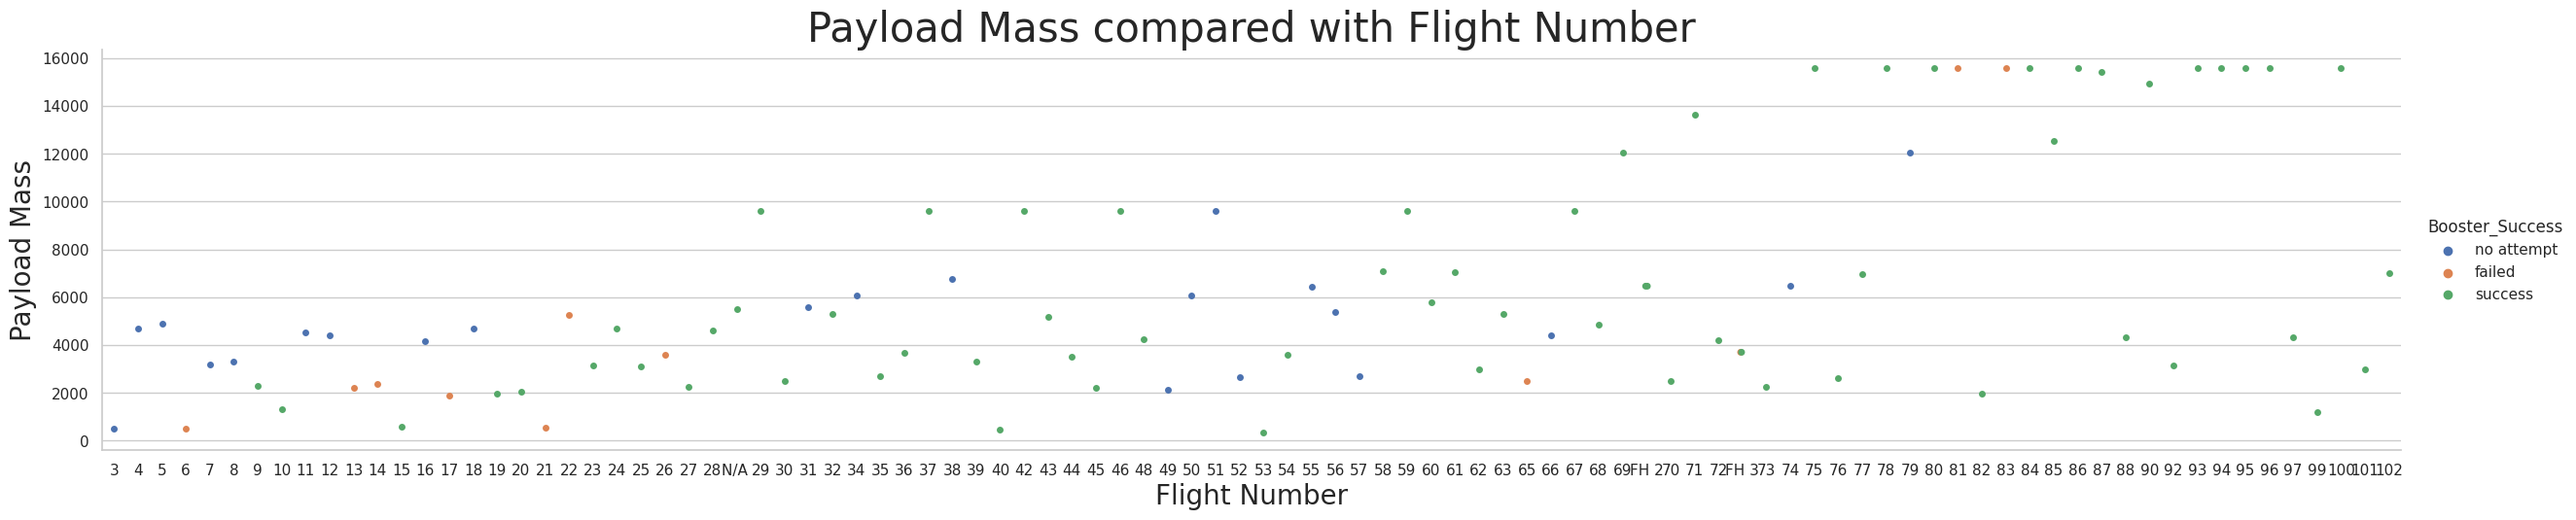

In [ ]:
sns.catplot(y="Payload_Mass", x="Flight Number", hue="Booster_Success", data=spacex, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Payload Mass",fontsize=20)
plt.title('Payload Mass compared with Flight Number',fontsize=30)
plt.show()

In the above scatter plot we compare the payload mass with the flight number, which is in correspondence with the date of the launch. It is clear that the average payload mass for launches has increased over time. Additionally, the frequency of failed booster landings has decreased with time.

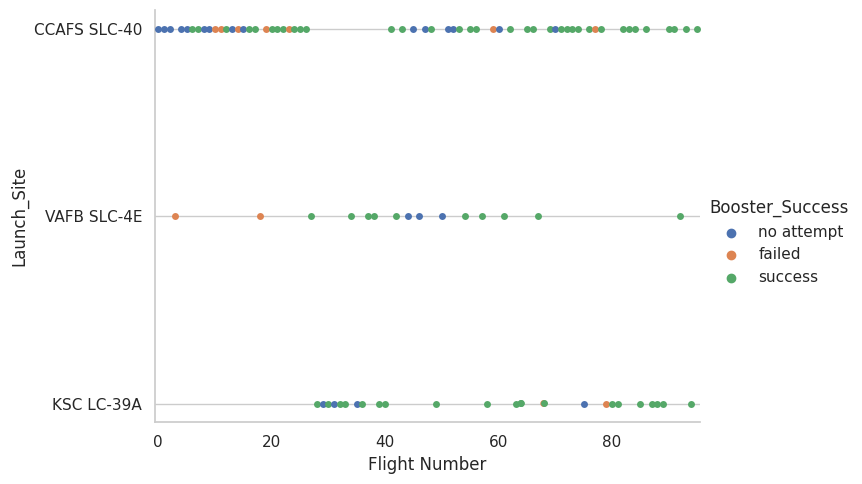

In [ ]:
catp = sns.catplot(data=spacex, x="Flight Number", y="Launch_Site", hue="Booster_Success", aspect=1.5)
for ax in catp.axes.flat:
    ax.set_xticks([0, 20, 40, 60, 80])
    ax.set_xticklabels([0, 20, 40, 60, 80])
plt.show()

In the above scatter plot we see the relationship between flight number and launch site. It is clear that as flight number increased, the use of CCASF continued but was supplemented by the use of KSC LC-39A after the first 25 flights.

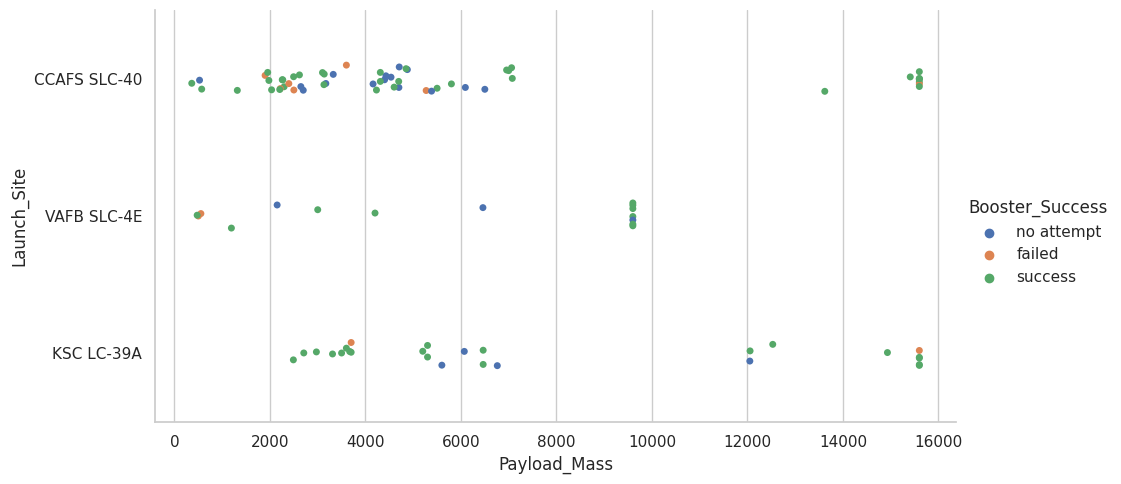

In [ ]:
sns.catplot(data=spacex,x="Payload_Mass",y="Launch_Site",hue="Booster_Success",aspect=2)

In [ ]:
mysql("select max(Payload_Mass), Launch_Site from spacextable group by Launch_Site")

,max(Payload_Mass),Launch_Site
0,15600.0,CCAFS SLC-40
1,15600.0,KSC LC-39A
2,9600.0,VAFB SLC-4E


In the above scatter plot we can see that there is a relationship between payload mass and launch site used. Notably notice that there is a lower maximum payload mass for launches from KSC LC-39A of 9600 kg vs. 15600 kg for the other two sites.

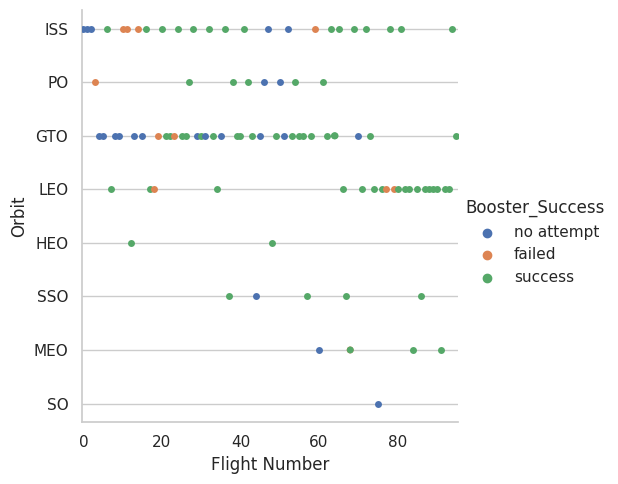

In [ ]:
catp=sns.catplot(data=spacex,x="Flight Number",y="Orbit",hue="Booster_Success")
for ax in catp.axes.flat:
    ax.set_xticks([0, 20, 40, 60, 80])
    ax.set_xticklabels([0, 20, 40, 60, 80])
plt.show()

In the above scatter plot we can see that there have been many more launches into LEO recently while in the beginning there were many more GTO launches.

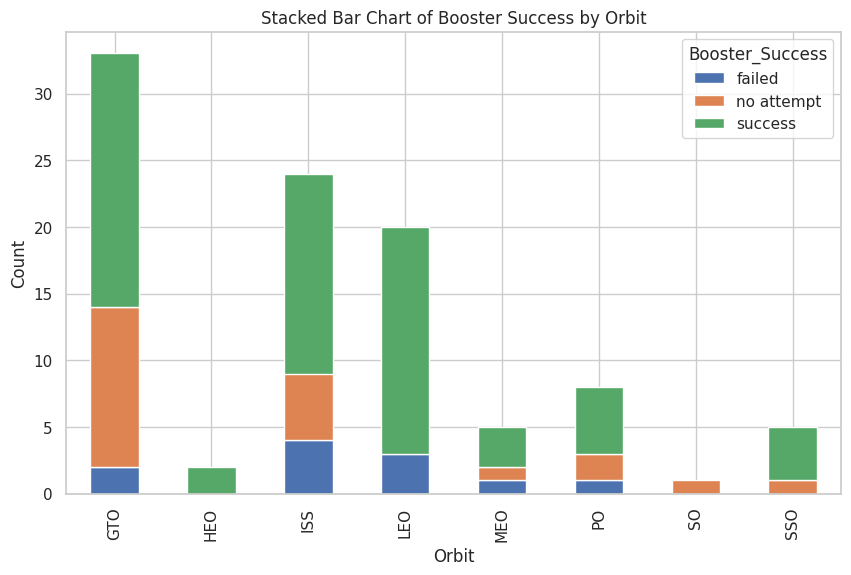

In [ ]:
pivot_df = spacex.pivot_table(index='Orbit', columns='Booster_Success', aggfunc='size', fill_value=0)

sns.set(style="whitegrid")
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Orbit')
ax.set_title('Stacked Bar Chart of Booster Success by Orbit')
plt.show()

In the above stacked bar graph we can see how many booster landings were successful when sorted by orbit type. It's notable that there are many more no attempts for GTo orbits, though not surprising as we say in the scatter plots that GTO orbit missions were more frequent with lower flight numbers when no attempts were more common across the board while LEO missions we saw have occured more frequently in the high flight number missions when there have been less no attempts.

#4. Machine Learning

We would like to use machine learning models to predict whether a booster landing will be successful based on payload mass, orbit type, launch site, and booster version. We will attempt this with logistic regression, SVM, decision tree, and KNN.

In the IBM lab we were given a dataset which had one-hot encoding for orbit type, launch site, and booster version. It also included data which was not scraped from wikipedia about if the flight had grid fins, if the booster was reused and how many times, and if it had legs. The dataset here does not contain those. As a result, all of our models are over fit and perform very poorly against the test data by predicting that every landing will be a success. I include those here and below them will run the same models against the provided IBM dataset which was obtained from the SpaceX API.

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

#Webscraped Data

In [ ]:
df = spacex
import re

In [ ]:
df['cleaned_boosters'] = [re.search(r'B\d{4}', booster).group() if re.search(r'B\d{4}', booster) else None for booster in df['Booster_Version']]
df.drop('Booster_Version',axis=1, inplace=True)

one-hot encoding of categorical variables orbit, launch site, and booster version

In [ ]:
one_hot_version = pd.get_dummies(df['cleaned_boosters'], prefix='Version')
df = pd.concat([df, one_hot_version], axis=1)
df.drop('cleaned_boosters', axis=1, inplace=True)
one_hot_orbit = pd.get_dummies(df['Orbit'], prefix='Orbit')
df = pd.concat([df, one_hot_orbit], axis=1)
df.drop('Orbit', axis=1, inplace=True)
one_hot_launch = pd.get_dummies(df['Launch_Site'], prefix='Site')
df = pd.concat([df, one_hot_launch], axis=1)
df.drop('Launch_Site', axis=1, inplace=True)
df.drop('Flight Number', axis=1, inplace=True)
df.drop('Date', axis=1, inplace=True)
df.drop('Payload', axis=1, inplace=True)
df.drop('Customer', axis=1, inplace=True)
df.drop('Outcome', axis=1, inplace=True)
df.drop('Booster_Success', axis=1, inplace=True)
df.drop('Landing', axis=1, inplace=True)
df.head()

,Payload_Mass,Version_B0005,Version_B0006,Version_B0007,Version_B1003,Version_B1004,Version_B1010,Version_B1011,Version_B1012,Version_B1013,...,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Site_CCAFS SLC-40,Site_KSC LC-39A,Site_VAFB SLC-4E
4,525.0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
6,4700.0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,4877.0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
11,500.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
13,3170.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Here we normalize our data using standard scaler.

In [ ]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(df)
X_df=pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,-1.214580,9.848858,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,...,-0.144338,1.755942,-0.50637,-0.231869,-0.298142,-0.101535,-0.231869,0.848115,-0.600925,-0.425115
1,-0.322425,-0.101535,9.848858,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,...,-0.144338,1.755942,-0.50637,-0.231869,-0.298142,-0.101535,-0.231869,0.848115,-0.600925,-0.425115
2,-0.284602,-0.101535,-0.101535,9.848858,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,...,-0.144338,1.755942,-0.50637,-0.231869,-0.298142,-0.101535,-0.231869,0.848115,-0.600925,-0.425115
3,-1.219923,-0.101535,-0.101535,-0.101535,9.848858,-0.101535,-0.101535,-0.101535,-0.101535,-0.101535,...,-0.144338,-0.569495,-0.50637,-0.231869,3.354102,-0.101535,-0.231869,-1.179086,-0.600925,2.352304
4,-0.649371,-0.101535,-0.101535,-0.101535,-0.101535,9.848858,-0.101535,-0.101535,-0.101535,-0.101535,...,-0.144338,-0.569495,-0.50637,-0.231869,-0.298142,-0.101535,-0.231869,0.848115,-0.600925,-0.425115


Here we convert our column Booster_Success into a numpy array with a 0 for a failure and a 1 for a success or a no attempt

In [ ]:
def booster_one(landing):
    def determine_one(cell):
        if "failed" in cell:
            return "0"
        else:
            return "1"

    return landing.apply(determine_one)


In [ ]:
y=booster_one(spacex["Booster_Success"])
Y=y.to_numpy()
type(Y)

numpy.ndarray

Now we do a train test split to get a training and testing set for our data.

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2, random_state=2)

##Logistic Regression
We will first use a logistic regression model to predict the outcome. We use a grid search to find  optimized parameters.

In [ ]:
parameters ={"C":[0.01,0.1,1]}
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters)
logreg_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1]})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01}
accuracy : 0.9125


Our grid search found that C=0.01 was the best choice and our model had an accuracy of 91.25%

In [ ]:
logreg_cv.score(X_test, Y_test)

0.8

Our model had an 80% accuracy on the test data.

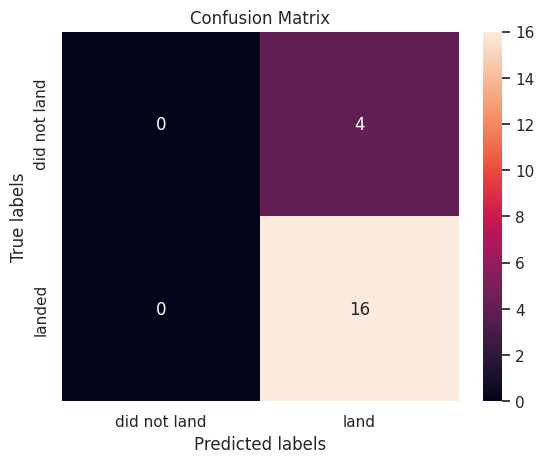

In [ ]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The confusion matrix shows that this accuracy is due to the model predicing that the booster will successfully land every time.

##Support Vector Machine

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters)
svm_cv.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 0.9125


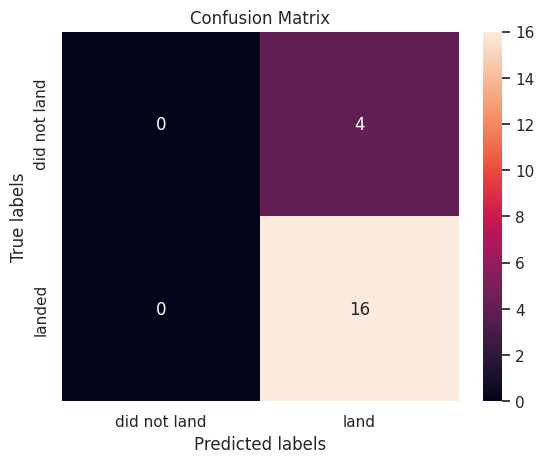

In [ ]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

##Decision Tree

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters)
tree_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.9125


In [ ]:
tree_cv.score(X_test, Y_test)

0.8

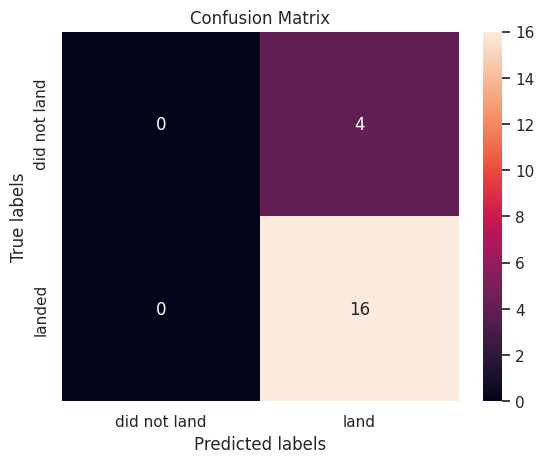

In [ ]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

##K-Nearest Neighbor

In [ ]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()


In [ ]:
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'p': [1, 2]})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9125


In [ ]:
knn_cv.score(X_test, Y_test)

0.8

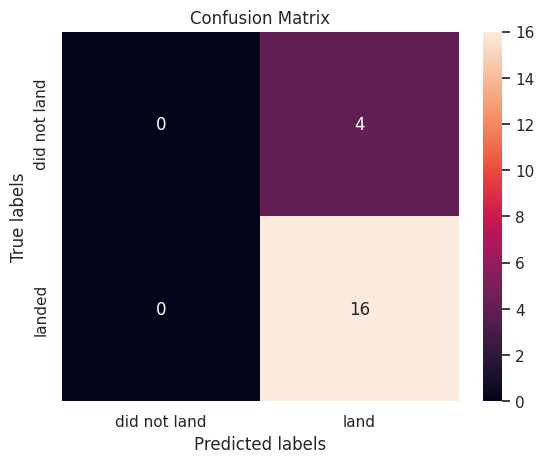

In [ ]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

# IBM Provided Data

In [ ]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X = pd.read_csv(URL2)

In [ ]:
Y=data["Class"].to_numpy()
type(Y)

numpy.ndarray

In [ ]:
transform = preprocessing.StandardScaler()
X=transform.fit_transform(X)
X_df=df = pd.DataFrame(X)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,-1.712912,-1.948145e-16,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
1,-1.674419,-1.195232e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
2,-1.635927,-1.162673e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,1.812654,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
3,-1.597434,-1.200587e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
4,-1.558942,-6.286706e-01,-0.653913,-1.575895,-0.97344,-0.106,-0.106,1.527525,-0.106,-0.551677,...,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2, random_state=2)

##Logistic Regression
We will first use a logistic regression model to predict the outcome. We use a grid search to find  optimized parameters.

In [ ]:
parameters ={"C":[0.01,0.1,1]}
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters)
logreg_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1]})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01}
accuracy : 0.8464285714285713


Our grid search found that C=0.01 was the best choice and our model had an accuracy of 84.64%

In [ ]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Our model had an 83.33% accuracy on the test data.

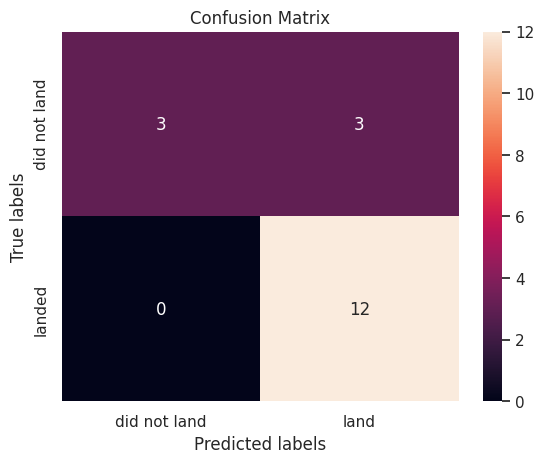

In [ ]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The confusion matrix shows that there are false positive predicions for half of the test data which did not land.

##Support Vector Machine

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters)
svm_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


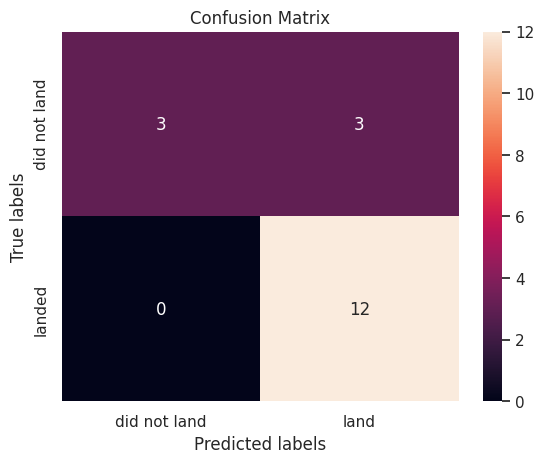

In [ ]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The SVM model performed indentically to the logistic regression model

##Decision Tree

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters)
tree_cv.fit(X_train, Y_train)


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.875


In [ ]:
tree_cv.score(X_test, Y_test)

0.7777777777777778

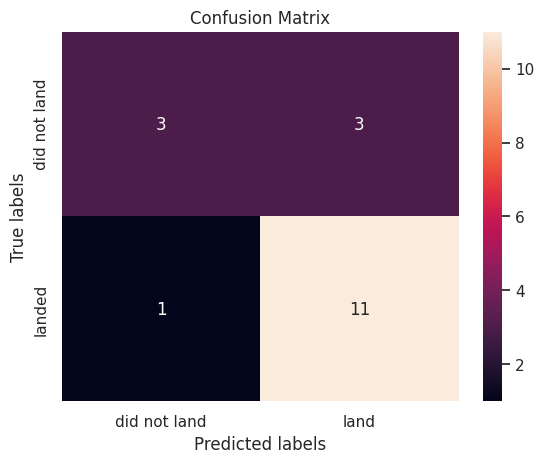

In [ ]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

The decision tree model retains the false position problem present in logistic regession and SVM. Additionally, it returns a false negative. The training accuracy is higher at 87.5% while the test accuracy is lower indicating that this model may be over fit.

##K-Nearest Neighbor

In [ ]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()


In [ ]:
knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'p': [1, 2]})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [ ]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

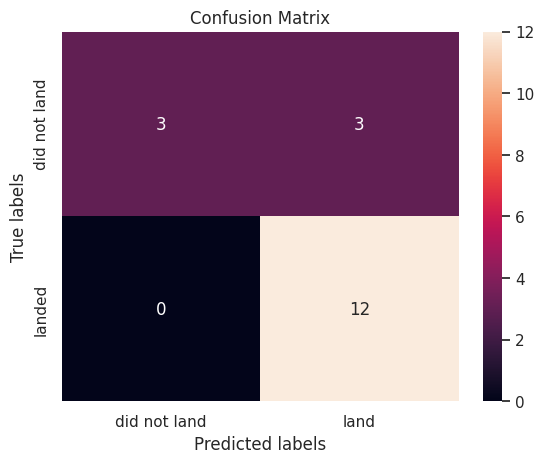

In [ ]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

KNN performed the same as logistic regression and SVM.

KNN, SVM, and Logistic regression all performed identically on both the training data and test set with a training accuracy of 84.82 and a test accuracy of 83.33.

Decision trees had a test accuracy of 87.5% and test accuracy of 77.77% indicating it likely is overfitted.